<a href="https://colab.research.google.com/github/higebobo/my-colab/blob/main/fisco_stock_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 出来た株・動いた株

* [出来た株・動いた株](https://market.fisco.co.jp/update/analysis/kabu.jsp)
* [【Python】Google ColaboratoryでSelenium実行｜ゆゆうブログ](https://yuyuublog.com/colaboratoryselenium/)

## 改定履歴

* 2022/12/21 pandas_datareaderがyahooからデータ取得できなくなったのでyfinanceに入れ替え
* 2022/11/28 初版

## Text version

### Install

In [ ]:
!apt-get update
!apt install chromium-chromedriver
!pip install pip --upgrade
!pip install selenium

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency t

### Import

In [ ]:
import re

from IPython.display import HTML, display
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

### Define variables

In [ ]:
wait = 1
url = 'https://market.fisco.co.jp/update/analysis/kabu.jsp'

pattern = '\*(.+)<(\d+)>\s(\d+)\s(.+\d+)\n(.+)'
rc = re.compile(pattern, re.MULTILINE | re.DOTALL)

# yahoo finance
stock_base_url = 'https://finance.yahoo.co.jp/quote/'

### Initialize

In [ ]:
options = webdriver.ChromeOptions()
options.desired_capabilities = DesiredCapabilities.CHROME
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
service = Service(executable_path='/usr/lib/chromium-browser/chromedriver')
driver = webdriver.Chrome(service=service, options=options)
driver.implicitly_wait(wait)

### Get data

In [ ]:
driver.get(url)

elem = driver.find_element(By.ID, 'ugodeki_uptime')
date_text = elem.text

elem = driver.find_element(By.ID, 'ugodeki')

word_list = re.findall(pattern, elem.text)

### Add information and sort

In [ ]:
word_list_updated = list()

for x in word_list:
    if x[3].startswith('+'):
        color = '#090'
        ratio = float(x[3]) / (float(x[2]) - float(x[3])) * 100
    elif x[3].startswith('-'):
        color = '#900'
        ratio = float(x[3]) / (float(x[2]) - float(x[3])) * 100
    else:
        color = '#000'
        ratio = 0
    word_list_updated.append(x + (color, ratio))

word_list_updated.sort(key=lambda x: x[6], reverse=True)

### Output

In [ ]:
output = '<h1>(フィスコ)出来た株・動いた株</h1>'
output += f'<h2>{date_text}</h2>'

output += '''
<table>
  <thead>
    <tr>
      <th>コード</th>
      <th>銘柄</th>
      <th>株価</th>
      <th colspan="2">変動価格</th>
      <th>コメント</th>
    </tr>
  </thead>
  <tfoot></tfoot>
  <tbody>
'''

for x in word_list_updated:
    output += f'''
        <tr>
          <td><a href="{stock_base_url}{x[1]}.T" target="_blank">{x[1]}</a></td>
          <td>{x[0]}</td>
          <td style="text-align: right;">{int(x[2]):,}円</td>
          <td style="color: {x[5]}; text-align: right">{x[3]}円</td>
          <td style="color: {x[5]}; text-align: right">{x[6]:1.2f}%</td>
          <td>{x[4]}</td>
        </tr>
    '''

output += '''
  </tbody>
</table>
'''
display(HTML(output))

## Chart version

### Install section

In [ ]:
!pip install mplfinance yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import section

In [ ]:
import base64
import datetime
from io import BytesIO

import mplfinance as mpf
import yfinance as yf

### Basic settings

In [ ]:
# Interval
# 本日まで(時差があるので補正)
end = datetime.date.today() + datetime.timedelta(days=1)
# start = end - datetime.timedelta(weeks=26) # 6 month
start = end - datetime.timedelta(weeks=26*2) # 1 year
# start = end - datetime.timedelta(weeks=26*4) # 2 year
# start = end - datetime.timedelta(weeks=26*10) # 5 year

params = {'start': start, 'end': end}

## 期間指定する場合
# 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
period = '3mo'

params = {'period': period}

### Output

**NOTE: It takes about 30 seconds**

**注意: 処理時間が30秒近くかかる**

銘柄情報,チャート
4274 細谷火工 1678円 +290円(20.89%) 防衛省では弾薬全体で8200億円超の予算を確保と伝わる。,
3446 ジェイテックコーポレーション 3555円 +555円(18.50%) PAP装置の開発機受注を発表。,
4275 カーリットＨＤ 793円 +87円(12.32%) 防衛関連の一角として人気化する展開へ。,
3562 Ｎｏ．１ 1245円 +113円(9.98%) 防衛関連物色がサイバーセキュリティ関連の一角にも波及か。,
8158 ソーダニッカ 683円 +54円(8.59%) 株主優待制度の一部変更と拡充を発表。,
7721 東京計器 1388円 +103円(8.02%) 防衛省の2023年度予算案報道を受けて防衛関連が一斉高に。,
6203 豊和工業 1006円 +72円(7.71%) 防衛関連の材料株として短期資金が向かう形に。,
4591 リボミック 214円 +15円(7.54%) 中国でRBM-007を臨床開発する合弁会社設立、最大137億円受領。,
6208 石川製作所 1611円 +105円(6.97%) 防衛関連の材料株としては中核的な存在でもあり。,
3053 ペッパーフードサービス 179円 +10円(5.92%) 短期底打ち感からの自律反発狙いか。,

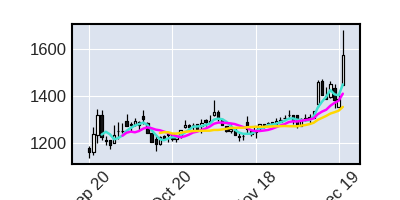
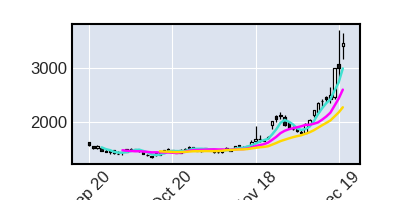
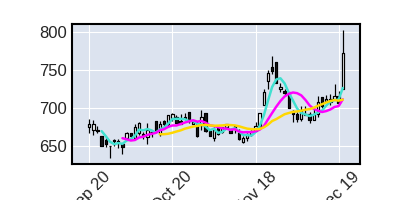
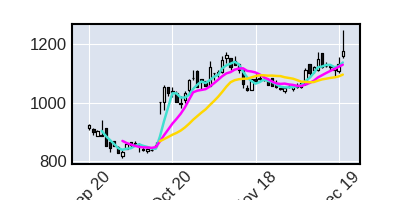
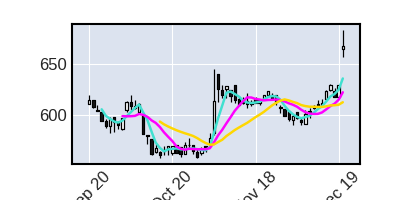
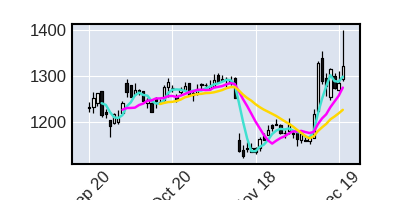
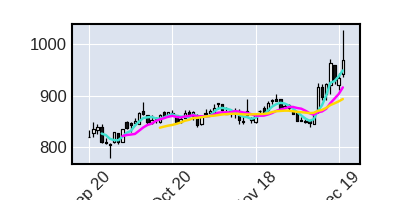
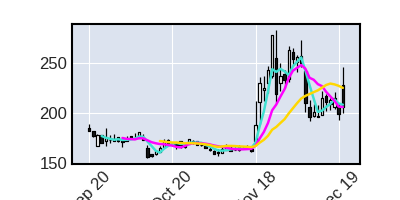
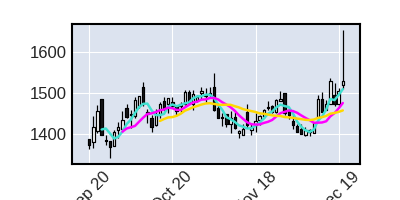
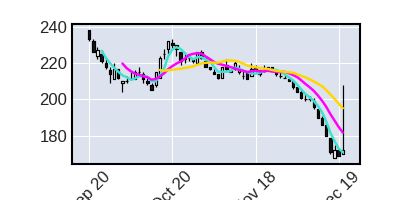
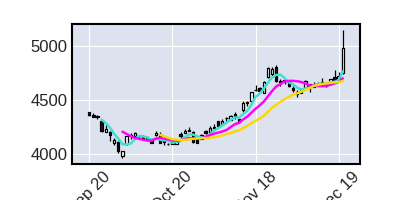
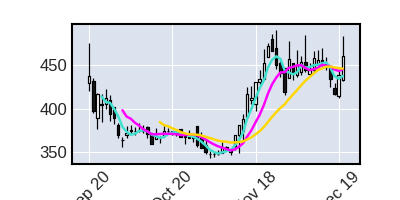
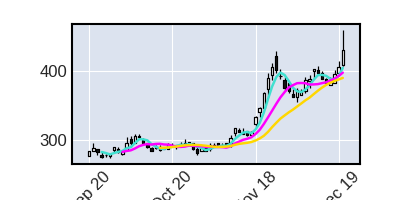
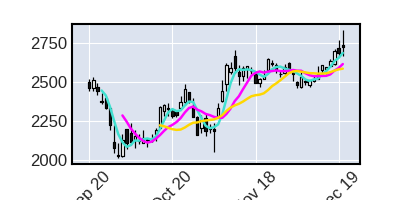
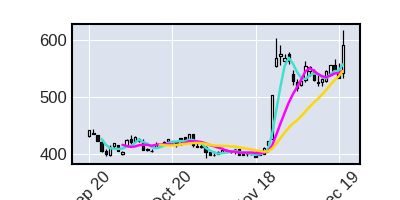
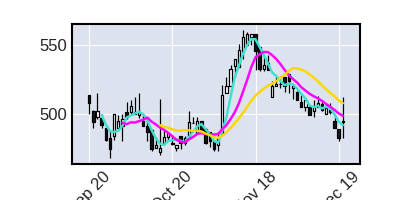
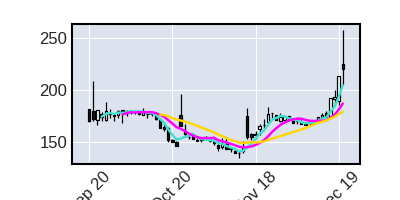
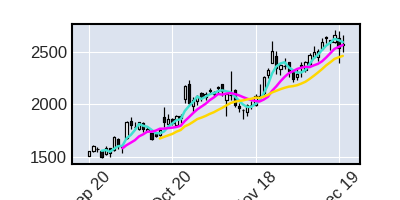
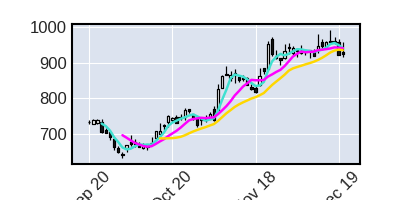
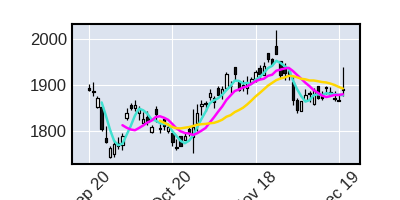
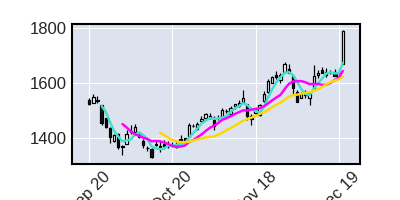
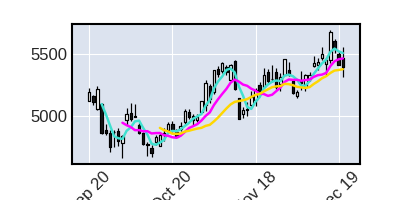
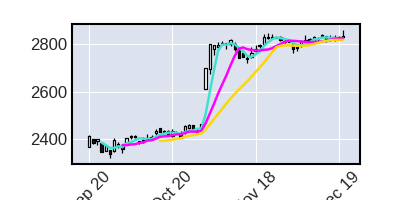
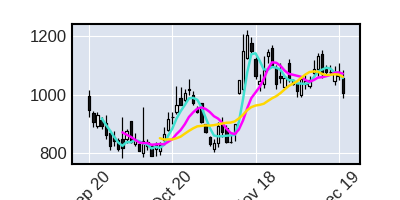
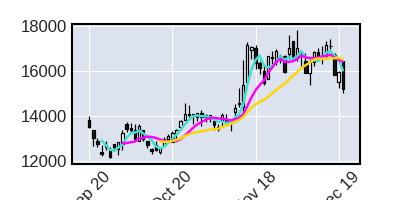
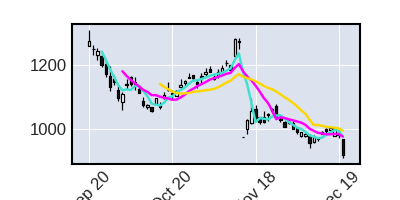
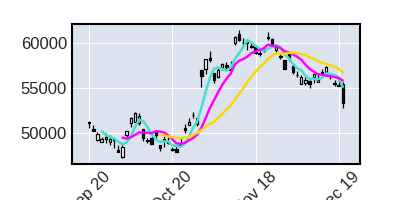
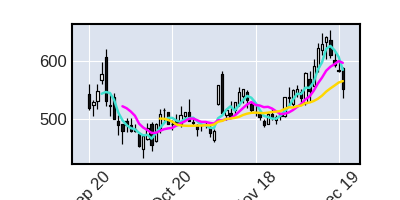
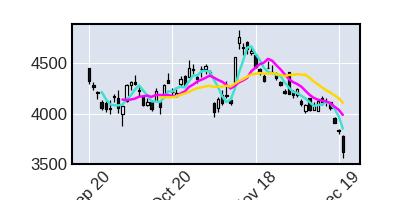
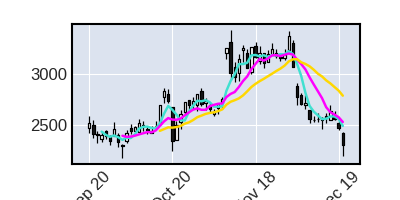
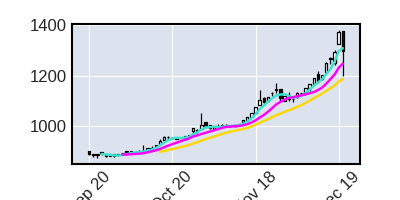
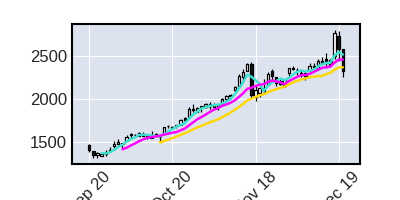
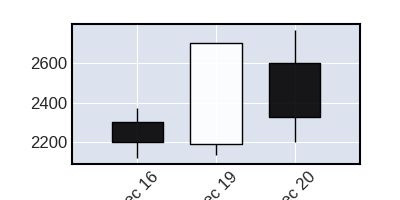
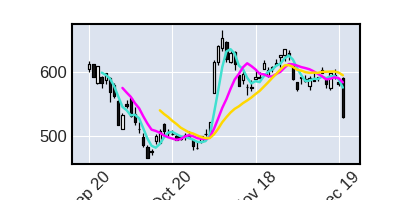
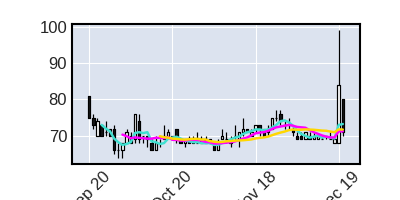
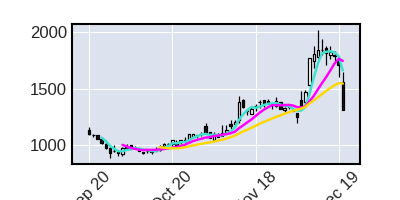
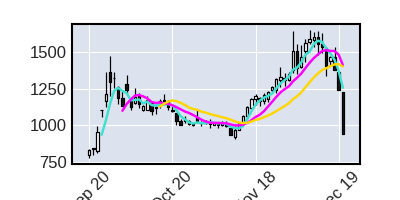

In [ ]:
output = '<h1>(フィスコ)出来た株・動いた株</h1>'
output += f'<h2>{date_text}</h2>'

output += '''
<table>
  <thead>
    <tr>
      <th>銘柄情報</th>
      <th>チャート</th>
    </tr>
  </thead>
  <tfoot></tfoot>
  <tbody>
'''

for x in word_list_updated:
    symbol = f'{x[1]}.T'
    stock_url = f'{stock_base_url}{symbol}'
    chart_url = f'{stock_url}/chart'
    
    df = yf.download(symbol, progress=False, **params)
    buffer = BytesIO()
    mpf.plot(df, type='candle', figsize=(4, 2), xlabel='', ylabel='', mav=(4, 9, 18), savefig=buffer)
    img = base64.b64encode(buffer.getvalue()).decode("ascii")

    output += f'''
        <tr>
          <td>
            <ul>
              <li><a href="{stock_url}" target="_blank">{x[1]}&nbsp;{x[0]}</a></li>
              <li>{x[2]}円&nbsp;<span style="color: {x[5]}">{x[3]}円({x[6]:1.2f}%)</span></li>
              <li>{x[4]}</li>
            </ul>            
          </td>
          <td><a href="{chart_url}" target="_blank"><img src="data:image/png;base64,{img}" /></a></td>
        </tr>
    '''
output += '''
  </tbody>
</table>
'''
display(HTML(output))